In [1]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
import pickle
import time

style.use('ggplot')

`Next, we need to decide on an environment size. We're making a square grid here. As noted before, size will make a massive impact on our learning time.`

`A 10x10 Q-Table for example, in this case, is ~15MB. A 20x20 is ~195MB`

In [2]:
SIZE = 10

## Creating few other constants

In [3]:
HM_EPISODES = 25000
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD = 25

epsilon = 0.9
EPS_DECAY = 0.9998

SHOW_EVERY = 3000 #how often do we want to show or how often to play through env visually.

start_q_table = None # if we have a pickled Q table, we'll put the filename of it here.

LEARNING_RATE = 0.1 #how quickly abandons current position in q-table for new value
DISCOUNT = 0.95 #priority to future awards than present

episode_rewards =  []

PLAYER_N = 1
FOOD_N = 2
ENEMY_N = 3

d = {1:(255,175,0), #player is blue
     2:(0,255,0),#food is green
     3:(0,0,255)} #Enemy is red







`Next this environment consists of blobs. These "blobs" are really just going to be squares, but, I am calling them blobs, alright?`

In [4]:
class Blob:
    def __init__(self):
        self.x = np.random.randint(0,SIZE)
        self.y = np.random.randint(0,SIZE)
        """So, we'll begin by initializing the blobs randomly.
        We could have the unfortunate environment where the enemy 
        and our blob, or the enemy and the food, are on the same 
        "tile" so to speak. Tough luck. For debugging purposes, 
        I wanted a string method:"""
        
    def __str__(self): #operator overloading
        return f"{self.x},{self.y}"
    
    """We need some sort of observation of our environment to use as our states.
    I propose we simply pass the x and y deltas for the food and enemy to 
    our agent. To make this easy, I am going to override the - (subtraction)
    operator, so we can just subtract two blobs from each other. 
    This method will look like:"""
    
    def __sub__(self,other): #operator overloading
        return (self.x - other.x, self.y-other.y)
    
    """Next, I'm going to add an "action" method, which will move based on 
    a "discrete" action being passed."""
    
    def action(self,choice):
        if choice == 0:
            self.move(x=1,y=1)
        elif choice == 1:
            self.move(x=-1,y=-1)
        elif choice ==2:
            self.move(x=-1,y=1)
        elif choice == 3:
            self.move(x=1,y=-1)
    
    def move(self,x=False,y=False):
        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1,2) #it will do -1,0 and 1
        else:
            self.x += x
        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y
            
         # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
            
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1
    
    

## Creating the q_table

In [5]:
if start_q_table is None: #if we don't have start_q_table we create one
    q_table = {}
    
    for x1 in range(-SIZE+1,SIZE):
        for y1 in range(-SIZE+1,SIZE):
            for x2 in range(-SIZE+1,SIZE):
                for y2 in range(-SIZE+1,SIZE):
                    q_table[((x1,y1),(x2,y2))]  = [np.random.uniform(-5,0) for i in range(4)]
                    #key is tuples of tuples.
                    #Each action space takes four random values. Because our action space is four
                    
else: #if we have q_table load old file
    with open(start_q_table,"rb") as f:
        q_table = pickle.load(f)
        
    
#This isn't the most efficient code ever, but it should cover all 
#of our basis. Despite the table being pretty large for Q-Learning, 
#Python should still be able to make quick work of generating a table of this size.

In [6]:
# For note, to look up on your Q-table, we would do something like:
print(q_table[((-9, -2), (3,8))])

[-4.534157943319912, -0.67998732647807, -4.89863640147671, -0.6213395758163278]


## start iterating over episodes!

on # 0 , epsilon:0.9
3000 ep mean: nan


C:\Users\Sumit\anaconda3\envs\tf1.5\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Sumit\anaconda3\envs\tf1.5\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on # 3000 , epsilon:0.49390083359356435
3000 ep mean: -172.94566666666665
on # 6000 , epsilon:0.27104225936046566
3000 ep mean: -114.33533333333334
on # 9000 , epsilon:0.14874221981913022
3000 ep mean: -82.29
on # 12000 , epsilon:0.08162656262136181
3000 ep mean: -70.165
on # 15000 , epsilon:0.044794919246742226
3000 ep mean: -60.254333333333335
on # 18000 , epsilon:0.024582497729691496
3000 ep mean: -46.942
on # 21000 , epsilon:0.01349035124500733
3000 ep mean: -40.226
on # 24000 , epsilon:0.0074032174726434705
3000 ep mean: -35.461


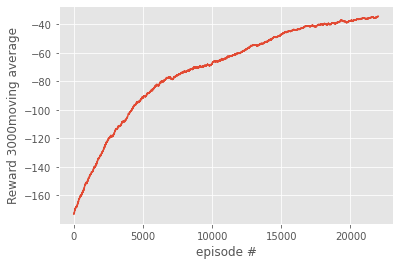

In [7]:
for episode in range(HM_EPISODES):
    player = Blob()
    food = Blob()
    enemy = Blob()
    
    """We will start tracking the episode rewards and their 
    improvements over time with episode_rewards. For each new episode, 
    we re-initialize the player, food, and enemy objects"""
    
    if episode % SHOW_EVERY == 0:
        print(f"on # {episode} , epsilon:{epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False
        
    # Now we start the actual frames/steps of the episode:
    episode_reward = 0
    for i in range(200):
        obs = (player-food,player-enemy)
        if np.random.random() > epsilon:
            action = np.argmax(q_table[obs]) # macimum value of observation
        else: 
            action = np.random.randint(0,4)
            
        # Take the action!
        player.action(action) #we take the action based on past moves
        
        
        #Codinng for reward purpose
        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
            
        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        
        else: 
            reward = -MOVE_PENALTY
            
        #work up our Q-table and Q-value information:
        ## NOW WE KNOW THE REWARD, LET'S CALC YO
        # first we need to obs immediately after the move.
        new_obs = (player-food,player-enemy) #new observation
        max_future_q = np.max(q_table[new_obs]) #max Q value for this new obs
        current_q = q_table[obs][action] # current Q for our chosen action
        
        
        #With these values, we can do our calculations:
        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        elif reward == -ENEMY_PENALTY:
            new_q = - ENEMY_PENALTY
        else:
            new_q = (1- LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
        #updating the q_table
        
        q_table[obs][action] = new_q
        
        #Showing the environment
        if show:
            env = np.zeros((SIZE,SIZE,3),dtype=np.uint8) #((0,256),(0,256),3)  #starts an rbg of our size #it will be all black environment inintally
            env[food.y][food.x] = d[FOOD_N] ## sets the food location tile to green color
            env[player.y][player.x] = d[PLAYER_N]  # sets the player tile to blue
            env[enemy.y][enemy.x] = d[ENEMY_N]  # sets the enemy location to red
            
            img = Image.fromarray(env,"RGB") ## reading to rgb. Apparently. Even tho color definitions are bgr. ???
            img = img.resize((300,300)) #resizing so we can see our agent in all its glory.
            cv2.imshow("",np.array(img)) #show it
            
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY :# if player gets food or touches enemy
                if cv2.waitKey(500) & 0xFF == ord("q"): #wait for 500ms or press q
                    break
                    
            else:
                if cv2.waitKey(1) & 0xFF == ord("q"): #wait for 1 ms
                    break
                    
        episode_reward += reward
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            break
                
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}moving average")
plt.xlabel("episode #")
plt.show()
    

with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)



            
        
        
        
        
            
    

In [ ]:
! git add CreatingOwnEnvironment.ipynb qtable-1622223713.pickle qtable-1622223974.pickle
! git commit -m "When training the model"
! git push origin main